In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.ticker import MultipleLocator
from scipy.stats import mannwhitneyu
from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.plotting import add_at_risk_counts
from lifelines.statistics import logrank_test, proportional_hazard_test
from sklearn.model_selection import LeaveOneOut
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import MinMaxScaler
from fpdf import FPDF

In [3]:
# Directory where the plots and PDF file will be saved
save_dir_path = 'output'

In [4]:
# Creating a random DataFrame

num_rows = 50

df = pd.DataFrame({
    'patient_id': np.random.randint(0, 9999, size=num_rows).astype(str),
    'feature_1': np.random.randint(0, 1001, size=num_rows),
    'feature_2': np.random.randint(0, 1001, size=num_rows),
    'response': np.random.randint(0, 2, size=num_rows),
    'os_months': np.random.uniform(0, 100, size=num_rows),
    'os_event': np.random.randint(0, 2, size=num_rows),
    'pfs_months': np.random.uniform(0, 100, size=num_rows),
    'pfs_event': np.random.randint(0, 2, size=num_rows)
})

In [5]:
# Setting the style for the plots
sns.set_style("white", {'axes.grid' : False})

In [6]:
def hist_plot(dataframe, feature, save_dir_path=None, bins=10):
    """Plot a histogram for the given feature"""
    plt.figure(figsize=(8, 5))
    sns.histplot(dataframe, x=feature, bins=bins)
    plt.title(f'Histogram')
    plt.tight_layout()
    if save_dir_path is not None:
        plt.savefig(f'{save_dir_path}/hist_{feature}.png', dpi=200)
    plt.show()

In [7]:
def violin_plot(dataframe, feature, save_dir_path=None, smoothing=0.3):
    """Plot a violin plot for the given feature"""
    palette = {0: '#ff7f0e', 1: '#1f77b4'}
    plt.figure(figsize=(8, 5))
    sns.violinplot(x='response', y=feature, data=dataframe, palette=palette, bw_adjust=smoothing, inner='quartile')
    plt.title(f'Violin plots')
    plt.tight_layout()
    if save_dir_path is not None:
        plt.savefig(f'{save_dir_path}/violin_{feature}.png', dpi=200)
    plt.show()

In [8]:
def waterfalls_plot(dataframe, feature, save_dir_path=None):
    """Waterfall plot for the given feature"""
    df = dataframe.dropna(subset=['response']).reset_index(drop=True)
    sorted_df = df.sort_values(by=feature, ascending=True)
    palette = {True: '#1f77b4', False: '#ff7f0e'}
    plt.figure(figsize=(8, 5))
    
    for _, row in sorted_df.iterrows():
        plt.bar(row['patient_id'], row[feature], width=1, color=palette[row['response']])

    plt.xlabel('Patients')
    plt.ylabel(feature)
    plt.xticks(rotation=90)

    true_patch = mpatches.Patch(color=palette[True], label='Responders')
    false_patch = mpatches.Patch(color=palette[False], label='Non-responders')
    plt.legend(handles=[true_patch, false_patch])
    
    plt.title(f'Waterfall plot')
    plt.tight_layout()
    if save_dir_path is not None:
        plt.savefig(f'{save_dir_path}/waterfall_{feature}.png', dpi=200)

    plt.show()

In [9]:
def km_plot(dataframe, feature, save_dir_path=None, num_curves=2, type='os', show_ci=False, ticks=12):
    """Plot Kaplan-Meier curves for the given feature, split into specified number of groups."""
    df = dataframe.dropna(subset=[f'{type}_event', f'{type}_months']).reset_index(drop=True)
    
    # Calculate quantile thresholds for splitting data
    thresholds = np.quantile(df[feature], np.linspace(0, 1, num_curves + 1))

    plt.figure(figsize=(8, 5))
    curves = []

    for i in range(num_curves):
        # Select data for each group
        if i == 0:
            group = df[df[feature] < thresholds[i+1]]
        elif i == num_curves - 1:
            group = df[df[feature] >= thresholds[i]]
        else:
            group = df[(df[feature] >= thresholds[i]) & (df[feature] < thresholds[i+1])]
        
        # Fit and plot KM curve for the group
        kmf = KaplanMeierFitter()
        kmf.fit(group[f'{type}_months'], event_observed=group[f'{type}_event'], label=f'Group {i+1}')
        kmf.plot(show_censors=True, ci_show=show_ci)
        curves.append(kmf)

    plt.xlabel('Months')
    plt.ylabel('Probability of survival')
    plt.ylim(0, 1.05)
    plt.gca().xaxis.set_major_locator(MultipleLocator(ticks))
    add_at_risk_counts(*curves, rows_to_show=['At risk'])
    
    plt.title(f'Kaplan-Meier curves ({num_curves}) {type.upper()}')
    plt.tight_layout()
    fig = plt.gcf()
    if save_dir_path is not None:
        fig.savefig(f'{save_dir_path}/km_{type}_{num_curves}_curves_{feature}.png', dpi=200)
    plt.show()

In [10]:
def mann_whitney_p(dataframe, feature):
    """Compute the Mann-Whitney U test for the given feature (response 0 vs 1) and returns the p-value"""
    df = dataframe.dropna(subset=['response']).reset_index(drop=True)
    table1 = df.loc[(df['response'] == 1)][feature]
    table2 = df.loc[(df['response'] == 0)][feature]
    stat, p = mannwhitneyu(table1, table2)
    return p

In [11]:
def logranktest(dataframe, feature, type='os'):
    """Compute the logrank test for the given feature and returns the p-value"""
    df = dataframe.dropna(subset=[f'{type}_event', f'{type}_months']).reset_index(drop=True)
    median_value = dataframe[feature].median()
    table1 = df.loc[(df[feature] >= median_value)]
    table2 = df.loc[(df[feature] < median_value)]
    
    lrt = logrank_test(
        durations_A=table1[f'{type}_months'],
        durations_B=table2[f'{type}_months'],
        event_observed_A=table1[f'{type}_event'],
        event_observed_B=table2[f'{type}_event']
    )
    return lrt.p_value

In [12]:
def cph_univariable_analysis(dataframe, feature, type='os', use_dichotomization=False):
    """For the Cox proportional hazard univariable analysis on a single feature,
    with an option to use dichotomization of the feature around the median value.
    It also includes testing the proportional hazards assumption using Schoenfeld residuals."""
    
    df = dataframe.dropna(subset=[f'{type}_event', f'{type}_months']).reset_index(drop=True)

    # Calculate median and dichotomize the feature if required
    if use_dichotomization:
        median_value = df[feature].median()
        df[f'{feature}_binary'] = df[feature].apply(lambda x: 1 if x >= median_value else 0)
        feature_to_use = f'{feature}_binary'
    else:
        feature_to_use = feature

    # Fit Cox proportional hazard model with the chosen feature
    results_dict = {}
    cphf = CoxPHFitter(penalizer=0.0001)
    df_filtered = df[[f'{type}_months', f'{type}_event', feature_to_use]].dropna()
    cphf.fit(df_filtered, duration_col=f'{type}_months', event_col=f'{type}_event')
    result = cphf.summary[['exp(coef)', 'exp(coef) lower 95%', 'exp(coef) upper 95%', 'p', 'coef', 'coef lower 95%', 'coef upper 95%']]

    # Store results in a dictionary
    for col in result.columns:
        results_dict[col] = result[col].values[0]
    results_dict['coef error'] = (result['coef upper 95%'].values[0] - result['coef lower 95%'].values[0]) / 2

    # Test proportional hazards assumption for the chosen feature and store p-value
    test_result = proportional_hazard_test(cphf, df_filtered, time_transform='rank')
    results_dict['assumption p'] = test_result.p_value[0]

    return results_dict

In [13]:
def logistic_regression_loocv_auc(dataframe, feature):
    """AUC from logistic regression with leave-one-out cross-validation"""
    df = dataframe.dropna(subset=['response']).reset_index(drop=True)
    X = df[[feature]]
    y = df['response'].astype(int)

    probabilities = []
    loo = LeaveOneOut()

    # Loop over each split
    for train_index, test_index in loo.split(X):
        # Split data into training and test sets
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = (y.iloc[train_index], y.iloc[test_index])

        # Scale data
        scaler = MinMaxScaler()
        X_train.loc[:, feature] = scaler.fit_transform(X_train[[feature]]).ravel()
        X_test.loc[:, feature] = scaler.transform(X_test[[feature]]).ravel()

        # Initialize and fit logistic regression model
        model = LogisticRegression(penalty='l2', class_weight='balanced', 
                                   fit_intercept=True, solver='liblinear',max_iter=100)
        model.fit(X_train, y_train)
        
        # Predict probability
        probability = model.predict_proba(X_test)
        probabilities.append(probability[0][1])

    # Calculate AUC
    auc = roc_auc_score(y, probabilities)

    return auc

In [14]:
def compute_stats(dataframe, feature):
    """Compute statistics for a feature"""
    results = {}
    results['Mann-Whitney p-value'] = mann_whitney_p(dataframe, feature)
    results['Logrank OS p-value'] = logranktest(dataframe, feature)
    results['Logrank PFS p-value'] = logranktest(dataframe, feature, type='pfs')
    cox_os = cph_univariable_analysis(dataframe, feature)
    cox_pfs = cph_univariable_analysis(dataframe, feature, type='pfs')
    cox_os_dichotomized = cph_univariable_analysis(dataframe, feature, use_dichotomization=True)
    cox_pfs_dichotomized = cph_univariable_analysis(dataframe, feature, type='pfs', use_dichotomization=True)
    results['Cox OS p-value'] = cox_os['p']
    results['Cox OS HR'] = cox_os['exp(coef)']
    results['Cox OS assumption p-value'] = cox_os['assumption p']
    results['Cox PFS p-value'] = cox_pfs['p']
    results['Cox PFS HR'] = cox_pfs['exp(coef)']
    results['Cox PFS assumption p-value'] = cox_pfs['assumption p']
    results['Cox OS dichotomized p-value'] = cox_os_dichotomized['p']
    results['Cox OS dichotomized HR'] = cox_os_dichotomized['exp(coef)']
    results['Cox OS dichotomized assumption p-value'] = cox_os_dichotomized['assumption p']
    results['Cox PFS dichotomized p-value'] = cox_pfs_dichotomized['p']
    results['Cox PFS dichotomized HR'] = cox_pfs_dichotomized['exp(coef)']
    results['Cox PFS dichotomized assumption p-value'] = cox_pfs_dichotomized['assumption p']
    results['Logistic regression LOOCV AUC'] = logistic_regression_loocv_auc(dataframe, feature)
    return results

In [15]:
def analyze_feature(dataframe, feature, save_dir_path):
    """
    Analyze a specific feature in a given dataframe and save the analysis results.

    This function performs various statistical analyses and visualizations on a specified feature in the dataframe. It generates histogram, violin, waterfall, and Kaplan-Meier plots, computes statistics, and then consolidates all the results into a PDF file saved in the specified directory.

    Parameters:
    - dataframe (pd.DataFrame): The dataframe containing the data to be analyzed. Must include the columns 'patient_id', 'response', 'os_months', 'os_event', 'pfs_months', and 'pfs_event', in addition to the features.
    - feature (str): The name of the feature (column in the dataframe) to be analyzed.
    - save_dir_path (str): The file path where the resulting plots and PDF file will be saved.
    """
    
    # Create plots and compute statistics
    hist_plot(dataframe, feature, save_dir_path)
    violin_plot(dataframe, feature, save_dir_path)
    waterfalls_plot(dataframe, feature, save_dir_path)
    km_plot(dataframe, feature, save_dir_path, 2, 'os')
    km_plot(dataframe, feature, save_dir_path, 3, 'os')
    km_plot(dataframe, feature, save_dir_path, 2, 'pfs')
    km_plot(dataframe, feature, save_dir_path, 3, 'pfs')
    stats = compute_stats(dataframe, feature)
    print(stats)
    
    # Create PDF file
    pdf = FPDF()
    pdf.set_top_margin(3)
    pdf.set_auto_page_break(auto=1, margin=1)
    pdf.add_page()
    pdf.set_font('Arial', '', 16)
    pdf.cell(0, 10, f'Features analysis: {feature}', align='C')
    pdf.ln()
    current_y = pdf.get_y()
    pdf.image(f'{save_dir_path}/hist_{feature}.png', y=current_y, w=90, h=0)
    pdf.image(f'{save_dir_path}/violin_{feature}.png', x=110, y=current_y, w=90, h=0)
    pdf.ln(50 + 5)
    pdf.image(f'{save_dir_path}/waterfall_{feature}.png', w=90, h=0)
    current_y = pdf.get_y()
    pdf.image(f'{save_dir_path}/km_os_2_curves_{feature}.png', y=current_y, w=90, h=0)
    pdf.image(f'{save_dir_path}/km_pfs_2_curves_{feature}.png', x=110, y=current_y, w=90, h=0)
    pdf.ln(50 + 5)
    current_y = pdf.get_y()
    pdf.image(f'{save_dir_path}/km_os_3_curves_{feature}.png', y=current_y, w=90, h=0)
    pdf.image(f'{save_dir_path}/km_pfs_3_curves_{feature}.png', x=110, y=current_y, w=90, h=0)
    pdf.ln(50 + 5)
    pdf.set_font('Arial', '', 10)
    pdf.cell(40, 10, f'Not dichotomized:', ln=0)
    pdf.cell(70, 10, f'Cox OS HR: {round(stats["Cox OS HR"], 5)}', ln=0)
    pdf.cell(70, 10, f'Cox PFS HR: {round(stats["Cox PFS HR"], 5)}')
    pdf.ln(5)
    pdf.cell(40, 10, f'', ln=0)
    pdf.cell(70, 10, f'Cox OS p-value: {round(stats["Cox OS p-value"], 5)}', ln=0)
    pdf.cell(70, 10, f'Cox PFS p-value: {round(stats["Cox PFS p-value"], 5)}')
    pdf.ln(5)
    pdf.cell(40, 10, f'', ln=0)
    pdf.cell(70, 10, f'Cox OS ph assumption p-value: {round(stats["Cox OS assumption p-value"], 5)}', ln=0)
    pdf.cell(70, 10, f'Cox PFS ph assumption p-value: {round(stats["Cox PFS assumption p-value"], 5)}')
    pdf.ln(7)
    pdf.cell(40, 10, f'Dichotomized:', ln=0)
    pdf.cell(70, 10, f'logrank OS p-value: {round(stats["Logrank OS p-value"], 5)}', ln=0)
    pdf.cell(70, 10, f'logrank PFS p-value: {round(stats["Logrank PFS p-value"], 5)}')
    pdf.ln(5)
    pdf.cell(40, 10, f'', ln=0)
    pdf.cell(70, 10, f'Cox OS HR: {round(stats["Cox OS dichotomized HR"], 5)}', ln=0)
    pdf.cell(70, 10, f'Cox PFS HR: {round(stats["Cox PFS dichotomized HR"], 5)}')
    pdf.ln(5)
    pdf.cell(40, 10, f'', ln=0)
    pdf.cell(70, 10, f'Cox OS p-value: {round(stats["Cox OS dichotomized p-value"], 5)}', ln=0)
    pdf.cell(70, 10, f'Cox PFS p-value: {round(stats["Cox PFS dichotomized p-value"], 5)}')
    pdf.ln(5)
    pdf.cell(40, 10, f'', ln=0)
    pdf.cell(70, 10, f'Cox OS ph assumption p-value: {round(stats["Cox OS dichotomized assumption p-value"], 5)}', ln=0)
    pdf.cell(70, 10, f'Cox PFS ph assumption p-value: {round(stats["Cox PFS dichotomized assumption p-value"], 5)}')
    pdf.ln(7)
    pdf.cell(40, 10, f'Distribution:', ln=0)
    pdf.cell(70, 10, f'Mann-Whitney p-value: {round(stats["Mann-Whitney p-value"], 5)}')
    pdf.ln(7)
    pdf.cell(40, 10, f'Prediction:', ln=0)
    pdf.cell(70, 10, f'AUC logistic regression LOOCV: {round(stats["Logistic regression LOOCV AUC"], 5)}')
    pdf.ln(5)
    pdf.output(f'{save_dir_path}/{feature}.pdf', 'F')
    print(f'\n PDF saved in {save_dir_path}/{feature}.pdf')

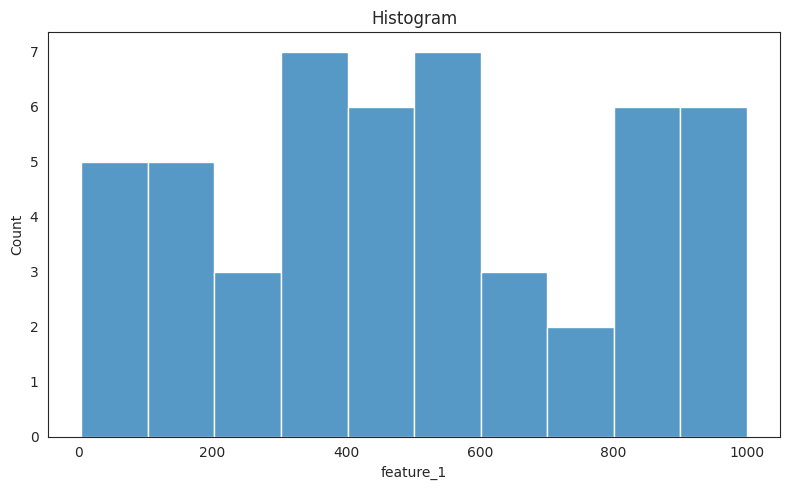

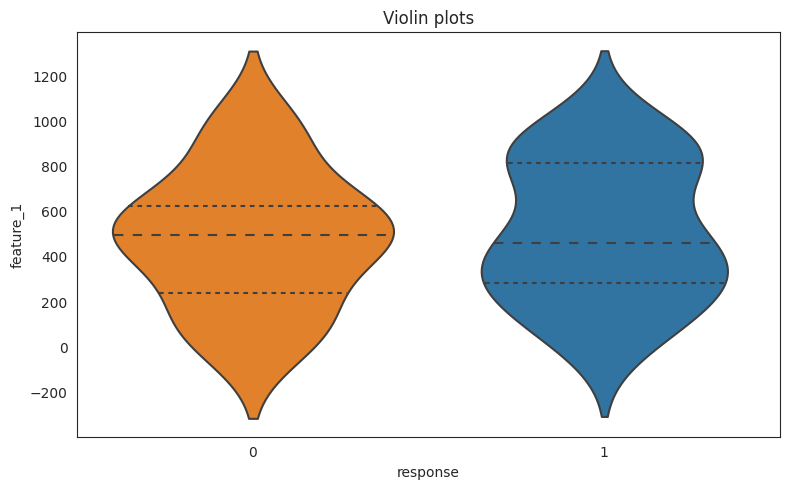

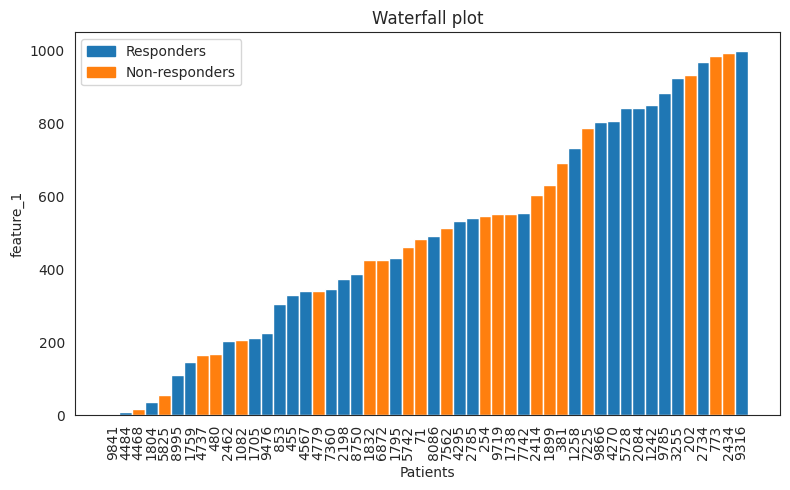

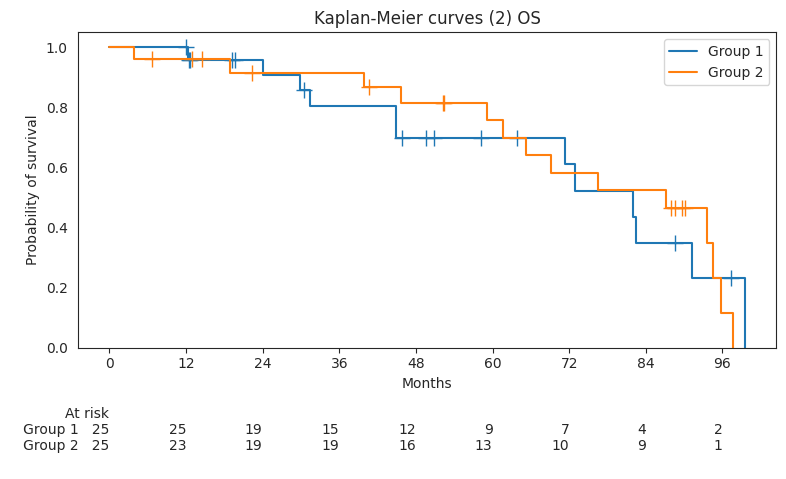

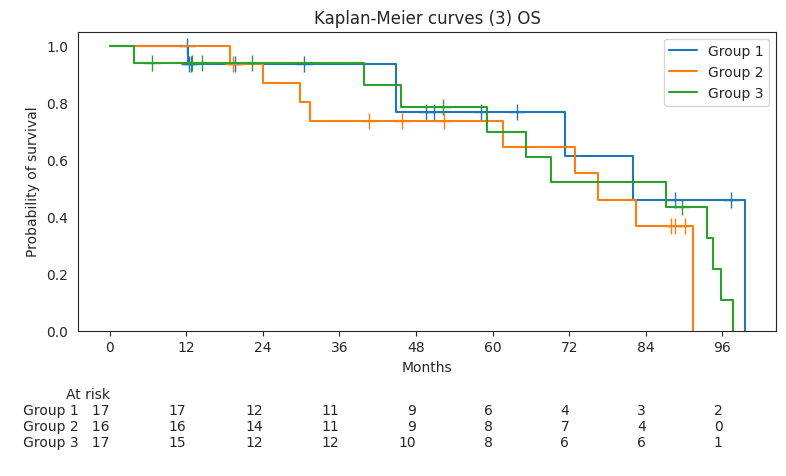

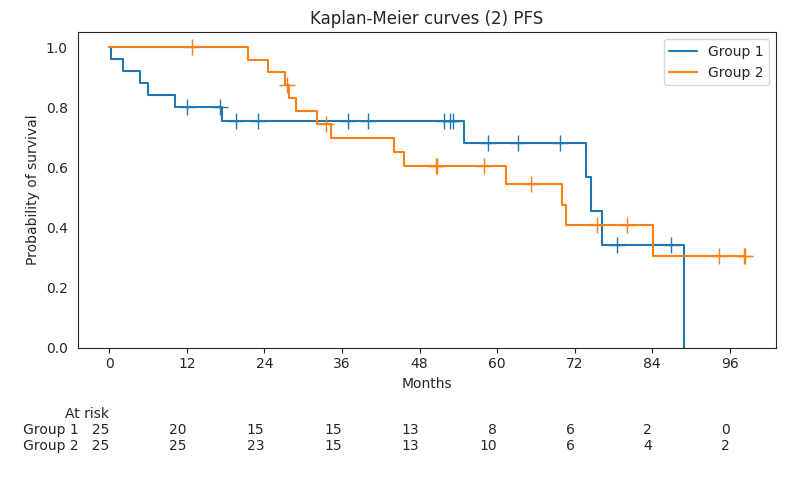

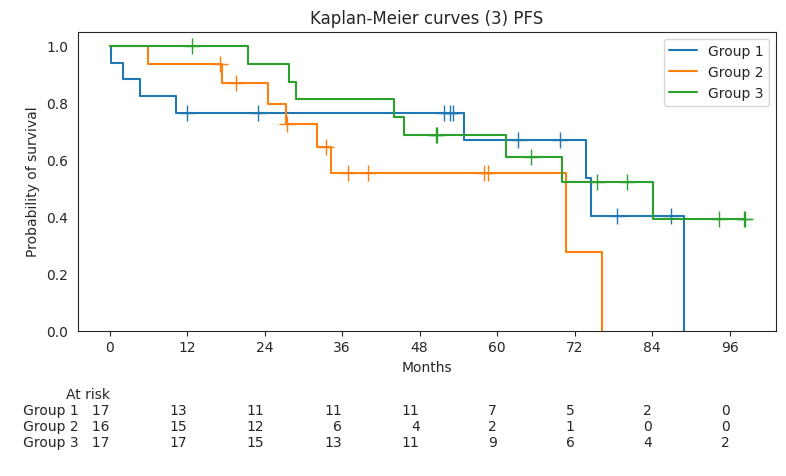

{'Mann-Whitney p-value': 0.8680557091357268, 'Logrank OS p-value': 0.9444869875041807, 'Logrank PFS p-value': 0.8585796371682386, 'Cox OS p-value': 0.5620969593427172, 'Cox OS HR': 1.0004010356650836, 'Cox OS assumption p-value': 0.14884487875613883, 'Cox PFS p-value': 0.390953017455713, 'Cox PFS HR': 0.9994393511105311, 'Cox PFS assumption p-value': 0.713143396488451, 'Cox OS dichotomized p-value': 0.9446284840965659, 'Cox OS dichotomized HR': 0.972239101082287, 'Cox OS dichotomized assumption p-value': 0.4253157923499826, 'Cox PFS dichotomized p-value': 0.8589501972101485, 'Cox PFS dichotomized HR': 0.9293682571029623, 'Cox PFS dichotomized assumption p-value': 0.558489848149159, 'Logistic regression LOOCV AUC': 0.38311688311688313}

 PDF saved in output/feature_1.pdf


In [16]:
analyze_feature(df, 'feature_1', save_dir_path)